In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [2]:
# Problem parameters
coach_prices = [300, 350]
first_prices = [425, 500]
coach_show_probs = [0.05, 0.95]
first_show_probs = [0.03, 0.97]
coach_selling_probs = [0.65, 0.30]
first_selling_probs = [0.08, 0.04]
discount_rate = 0.17
discount_factor = 1 / (1 + 0.17 / 365)  # discount rate
coach_seats = 100  # number of coach seats on plane
first_seats = 20  # number of first-class seats on plane
bump_to_first_cost = 50
bump_off_flight_cost = 425
days_until_departure = 365  # days until takeoff

**1. Finding Expected Discounted Profit (overbooking limt = 5)**

In [15]:
def calculate_value_function(coach_prices, first_prices, coach_show_probs, first_show_probs,
                             coach_selling_probs, first_selling_probs, discount_factor, overbooking_limit,
                             coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost, days_until_departure):
    # initialize values
    first_values = np.arange(first_seats + 1)
    coach_values = np.arange(coach_seats + overbooking_limit + 1)
    time_values = np.arange(days_until_departure + 1)
    coach_states, first_states, time_states = len(coach_values), len(first_values), len(time_values)

    # Initialize value function and optimal choice variable
    value_function = np.zeros((coach_states, first_states, time_states))
    optimal_choice = np.zeros((coach_states, first_states, time_states))
    coach_optimal_choice = np.zeros((coach_states, first_states, time_states))
    first_optimal_choice = np.zeros((coach_states, first_states, time_states))

    # Calculate overbooking costs
    cost_values = calculate_overbooking_costs(coach_states, first_states, coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost)

    # Set terminal condition
    set_terminal_condition(value_function, optimal_choice, coach_states, first_states, time_states, cost_values, coach_show_probs, first_show_probs)

    # Backward induction
    for t in reversed(range(time_states - 1)):
        for sc in range(coach_states):
            for sf in range(first_states):
                value_function[sc, sf, t], optimal_choice[sc, sf, t], coach_optimal_choice[sc, sf, t], first_optimal_choice[sc, sf, t] = compute_optimal_value_and_choice(sc, sf, t, value_function, coach_prices, first_prices,
                                                                                                         coach_selling_probs, first_selling_probs,
                                                                                                         discount_factor, coach_seats, first_seats, overbooking_limit)

    return value_function, optimal_choice, coach_optimal_choice, first_optimal_choice

In [4]:
def calculate_overbooking_costs(coach_states, first_states, coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost):
    cost_values = np.zeros((coach_states, first_states))
    for sc in range(coach_states):
        for sf in range(first_states):
            if sc <= coach_seats:
                cost_values[sc, sf] = 0
            elif (sc - coach_seats) <= (first_seats - sf):
                cost_values[sc, sf] = (sc - coach_seats) * bump_to_first_cost
            else:
                cost_values[sc, sf] = (first_seats - sf) * bump_to_first_cost + (sc - coach_seats - (first_seats - sf)) * bump_off_flight_cost
    return cost_values

In [5]:
def set_terminal_condition(value_function, optimal_choice, coach_states, first_states, time_states, cost_values, coach_show_probs, first_show_probs):
    for sc in range(coach_states):
        for sf in range(first_states):
            if sc <= 100:
                value_function[:, :, time_states - 1] = 0
            else:
                running_cost = 0
                for i in range(sc + 1):
                    for j in range(sf + 1):
                        prob_c = binom.pmf(i, sc, coach_show_probs[1])
                        prob_f = binom.pmf(j, sf, first_show_probs[1])
                        running_cost += cost_values[i, j] * prob_c * prob_f
                value_function[sc, sf, time_states - 1] = -running_cost
    optimal_choice[:, :, time_states - 1] = 0

In [14]:
def compute_optimal_value_and_choice(sc, sf, t, value_function, coach_prices, first_prices, coach_selling_probs, first_selling_probs, discount_factor, coach_seats, first_seats, overbooking_limit):
    if (sc == (coach_seats + overbooking_limit)) and (sf == (first_seats)):
        value = discount_factor * value_function[sc, sf, t + 1]
        choice = 0
        coach_price_idx = -1  # No coach price available
        first_price_idx = -1  # No first-class price available
    elif (sc == (coach_seats + overbooking_limit)) and (sf != (first_seats)):
        values = []
        choices = []
        first_choices = []
        for price_idx, price in enumerate(first_prices):
            value = price * first_selling_probs[price_idx] + discount_factor * (
                (1 - first_selling_probs[price_idx]) * value_function[sc, sf, t + 1] +
                first_selling_probs[price_idx] * value_function[sc, sf + 1, t + 1])
            values.append(value)
            first_choices.append(price_idx)
            choices.append(price_idx + 1)
        value = max(values)
        choice = choices[values.index(value)]
        coach_price_idx = -1  # No coach price available
        first_price_idx = first_choices[values.index(value)]  # First-class price index
    elif (sc != (coach_seats + overbooking_limit)) and (sf == (first_seats)):
        coach_selling_probs = [0.68, 0.33]
        values = []
        choices = []
        coach_choices = []
        for price_idx, price in enumerate(coach_prices):
            value = price * coach_selling_probs[price_idx] + discount_factor * (
                (1 - coach_selling_probs[price_idx]) * value_function[sc, sf, t + 1] +
                coach_selling_probs[price_idx] * value_function[sc + 1, sf, t + 1])
            values.append(value)
            coach_choices.append(price_idx)
            choices.append(price_idx + 1)
        value = max(values)
        choice = choices[values.index(value)]
        coach_price_idx = coach_choices[values.index(value)] # Coach price index
        first_price_idx = -1  # No first-class price available
    else:
        coach_selling_probs = [0.65, 0.30]
        values = []
        choices = []
        coach_choices = []
        first_choices = []
        for coach_price_idx, coach_price in enumerate(coach_prices):
            for first_price_idx, first_price in enumerate(first_prices):
                value = coach_price * coach_selling_probs[coach_price_idx] + first_price * first_selling_probs[first_price_idx] + discount_factor * (
                    (1 - coach_selling_probs[coach_price_idx]) * (1 - first_selling_probs[first_price_idx]) * value_function[sc, sf, t + 1] +
                    coach_selling_probs[coach_price_idx] * (1 - first_selling_probs[first_price_idx]) * value_function[sc + 1, sf, t + 1] +
                    (1 - coach_selling_probs[coach_price_idx]) * first_selling_probs[first_price_idx] * value_function[sc, sf + 1, t + 1] +
                    coach_selling_probs[coach_price_idx] * first_selling_probs[first_price_idx] * value_function[sc + 1, sf + 1, t + 1])
                values.append(value)
                coach_choices.append(coach_price_idx)
                first_choices.append(first_price_idx)
                choices.append(coach_price_idx + 1 + (first_price_idx + 1) * 2)
        value = max(values)
        choice = choices[values.index(value)]
        coach_price_idx = coach_choices[values.index(value)]
        first_price_idx = first_choices[values.index(value)] 
        
    return value, choice, coach_price_idx, first_price_idx

In [7]:
overbooking_limit = 5

# Compute value function and optimal policy
value_function, optimal_choice, coach_optimal_choice, first_optimal_choice = calculate_value_function(coach_prices, first_prices, coach_show_probs, first_show_probs,
                                                               coach_selling_probs, first_selling_probs, discount_factor, overbooking_limit,
                                                               coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost, days_until_departure)
# Access the expected discounted profit
expected_profit = value_function[0, 0, 0]
print(f"The expected discounted profit is: {expected_profit:.2f}")

The expected discounted profit is: 41886.16


**2. Finding Optimal Overbooking Policy**

In [8]:
# Find the optimal overbooking limit
optimal_overbooking_limit = None
max_expected_profit = float('-inf')
expected_profits = []
overbooking_limits = []

for overbooking_limit in range(6, 16):
    value_function, optimal_choice, coach_price_idx, first_price_idx = calculate_value_function(coach_prices, first_prices, coach_show_probs, first_show_probs,
                                                               coach_selling_probs, first_selling_probs, discount_factor, overbooking_limit,
                                                               coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost, days_until_departure)
    expected_profit = value_function[0, 0, 0]
    print(f"Overbooking Limit: {overbooking_limit} Expected profit: {expected_profit:.2f}")
    expected_profits.append(expected_profit)
    overbooking_limits.append(overbooking_limit)

# Find the optimal overbooking limit
optimal_overbooking_limit = overbooking_limits[np.argmax(expected_profits)]
max_expected_profit = max(expected_profits)

print(f"The optimal overbooking limit is: {optimal_overbooking_limit}")
print(f"The maximum expected discounted profit is: {max_expected_profit:.2f}")

Overbooking Limit: 6 Expected profit: 42011.22
Overbooking Limit: 7 Expected profit: 42085.54
Overbooking Limit: 8 Expected profit: 42122.17
Overbooking Limit: 9 Expected profit: 42134.62
Overbooking Limit: 10 Expected profit: 42132.90
Overbooking Limit: 11 Expected profit: 42123.67
Overbooking Limit: 12 Expected profit: 42111.03
Overbooking Limit: 13 Expected profit: 42097.42
Overbooking Limit: 14 Expected profit: 42084.11
Overbooking Limit: 15 Expected profit: 42071.74
The optimal overbooking limit is: 9
The maximum expected discounted profit is: 42134.62


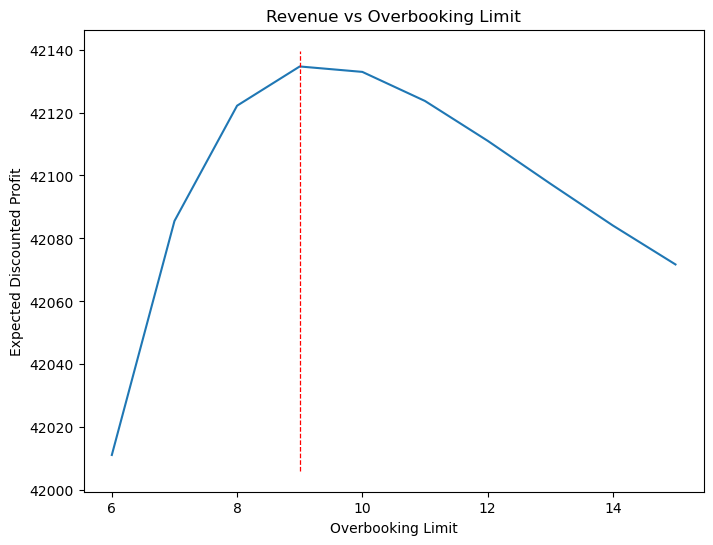

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(overbooking_limits, expected_profits)
plt.vlines(optimal_overbooking_limit, np.min(expected_profits) - 5, np.max(expected_profits) + 5, colors='r', linestyles='dashed', linewidth=0.9,
           label=f'Optimal Overbook Policy (={optimal_overbooking_limit})')
plt.xlabel('Overbooking Limit')
plt.ylabel('Expected Discounted Profit')
plt.title('Revenue vs Overbooking Limit')
plt.show()

**3. Alternative Option With No Coach Ticket** 

In [10]:
def calculate_value_function_with_no_sales(coach_prices, first_prices, coach_show_probs, first_show_probs,
             coach_selling_probs, first_selling_probs, discount_factor, overbooking_limit,
                             coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost, days_until_departure):
    # initialize values
    first_values = np.arange(first_seats + 1)
    coach_values = np.arange(coach_seats + overbooking_limit + 1)
    time_values = np.arange(days_until_departure + 1)
    coach_states, first_states, time_states = len(coach_values), len(first_values), len(time_values)

    # Initialize value function and optimal choice variable
    value_function = np.zeros((coach_states, first_states, time_states))
    optimal_choice = np.zeros((coach_states, first_states, time_states))

    # Calculate overbooking costs
    cost_values = calculate_overbooking_costs(coach_states, first_states, coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost)

    # Set terminal condition
    set_terminal_condition(value_function, optimal_choice, coach_states, first_states, time_states, cost_values, coach_show_probs, first_show_probs)

    # Backward induction
    for t in reversed(range(time_states - 1)):
        for sc in range(coach_states):
            for sf in range(first_states):
                value_function[sc, sf, t], optimal_choice[sc, sf, t] = compute_optimal_value_and_choice(sc, sf, t, value_function, coach_prices, first_prices,
                                                                                                         coach_selling_probs, first_selling_probs,
                                                                                                         discount_factor, coach_seats, first_seats, overbooking_limit)

    return value_function, optimal_choice

def calculate_overbooking_costs(coach_states, first_states, coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost):
    cost_values = np.zeros((coach_states, first_states))
    for sc in range(coach_states):
        for sf in range(first_states):
            if sc <= coach_seats:
                cost_values[sc, sf] = 0
            elif (sc - coach_seats) <= (first_seats - sf):
                cost_values[sc, sf] = (sc - coach_seats) * bump_to_first_cost
            else:
                cost_values[sc, sf] = (first_seats - sf) * bump_to_first_cost + (sc - coach_seats - (first_seats - sf)) * bump_off_flight_cost
    return cost_values

def set_terminal_condition(value_function, optimal_choice, coach_states, first_states, time_states, cost_values, coach_show_probs, first_show_probs):
    for sc in range(coach_states):
        for sf in range(first_states):
            if sc <= 100:
                value_function[:, :, time_states - 1] = 0
            else:
                running_cost = 0
                for i in range(sc + 1):
                    for j in range(sf + 1):
                        prob_c = binom.pmf(i, sc, coach_show_probs[1])
                        prob_f = binom.pmf(j, sf, first_show_probs[1])
                        running_cost += cost_values[i, j] * prob_c * prob_f
                value_function[sc, sf, time_states - 1] = -running_cost
    optimal_choice[:, :, time_states - 1] = 0

def compute_optimal_value_and_choice(sc, sf, t, value_function, coach_prices, first_prices, coach_selling_probs, first_selling_probs,
                                     discount_factor, coach_seats, first_seats, overbooking_limit):
    if (sc == (coach_seats + overbooking_limit)) and (sf == (first_seats)):
        value = discount_factor * value_function[sc, sf, t + 1]
        choice = 0
    elif (sc == (coach_seats + overbooking_limit)) and (sf != (first_seats)):
        values = []
        choices = []
        for price_idx, price in enumerate(first_prices):
            value = price * first_selling_probs[price_idx] + discount_factor * (
                (1 - first_selling_probs[price_idx]) * value_function[sc, sf, t + 1] +
                first_selling_probs[price_idx] * value_function[sc, sf + 1, t + 1])
            values.append(value)
            choices.append(price_idx + 1)
        
        valueNL = first_prices[0] * first_selling_probs[0] + discount_factor * ((1 - first_selling_probs[0]) * value_function[sc, sf, t + 1] + first_selling_probs[0] * value_function[sc, sf + 1, t + 1])
        valueNH = first_prices[1] * first_selling_probs[1] + discount_factor * ((1 - first_selling_probs[1]) * value_function[sc, sf, t + 1] + first_selling_probs[1] * value_function[sc, sf + 1, t + 1])
        
        values.extend([valueNL, valueNH])
        choices.extend([4, 5])
        value = max(values)
        choice = choices[values.index(value)]
    elif (sc != (coach_seats + overbooking_limit)) and (sf == (first_seats)):
        coach_selling_probs = [0.68, 0.33]
        values = []
        choices = []
        for price_idx, price in enumerate(coach_prices):
            value = price * coach_selling_probs[price_idx] + discount_factor * (
                (1 - coach_selling_probs[price_idx]) * value_function[sc, sf, t + 1] +
                coach_selling_probs[price_idx] * value_function[sc + 1, sf, t + 1])
            values.append(value)
            choices.append(price_idx + 1)
        
        valueNL = discount_factor * value_function[sc, sf, t + 1]
        valueNH = discount_factor * value_function[sc, sf, t + 1]
        
        values.extend([valueNL, valueNH])
        choices.extend([4, 5])
        value = max(values)
        choice = choices[values.index(value)]
    else:
        coach_selling_probs = [0.65, 0.30]
        values = []
        choices = []
        for coach_price_idx, coach_price in enumerate(coach_prices):
            for first_price_idx, first_price in enumerate(first_prices):
                value = coach_price * coach_selling_probs[coach_price_idx] + first_price * first_selling_probs[first_price_idx] + discount_factor * (
                    (1 - coach_selling_probs[coach_price_idx]) * (1 - first_selling_probs[first_price_idx]) * value_function[sc, sf, t + 1] +
                    coach_selling_probs[coach_price_idx] * (1 - first_selling_probs[first_price_idx]) * value_function[sc + 1, sf, t + 1] +
                    (1 - coach_selling_probs[coach_price_idx]) * first_selling_probs[first_price_idx] * value_function[sc, sf + 1, t + 1] +
                    coach_selling_probs[coach_price_idx] * first_selling_probs[first_price_idx] * value_function[sc + 1, sf + 1, t + 1])
                values.append(value)
                choices.append(coach_price_idx + 1 + (first_price_idx + 1) * 2)
                
        valueNL = first_prices[0] * first_selling_probs[0] + discount_factor * ((1 - first_selling_probs[0]) * value_function[sc, sf, t + 1] + first_selling_probs[0] * value_function[sc, sf + 1, t + 1])
        valueNH = first_prices[1] * first_selling_probs[1] + discount_factor * ((1 - first_selling_probs[1]) * value_function[sc, sf, t + 1] + first_selling_probs[1] * value_function[sc, sf + 1, t + 1])
        
        values.extend([valueNL, valueNH])
        choices.extend([4, 5])
        value = max(values)
        choice = choices[values.index(value)]

    return value, choice

In [11]:
overbooking_limit = 20

# Compute value function and optimal policy with the option to not sell coach tickets
value_function, optimal_choice = calculate_value_function_with_no_sales(coach_prices, first_prices, coach_show_probs, first_show_probs,
                                                                         coach_selling_probs, first_selling_probs, discount_factor, overbooking_limit,
                                                                         coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost, days_until_departure)

# Access the expected discounted profit
expected_profit = value_function[0, 0, 0]
print(f"The expected discounted profit with the option to not sell coach tickets is: {expected_profit:.2f}")

The expected discounted profit with the option to not sell coach tickets is: 42139.89


**4. Simulate Solution Forward in Time**

In [16]:
optimal_overbooking_limit = 9 
# Compute value function and optimal policy
value_function, optimal_choice, coach_optimal_choice, first_optimal_choice = calculate_value_function(coach_prices, first_prices, coach_show_probs, first_show_probs,
                                                               coach_selling_probs, first_selling_probs, discount_factor, optimal_overbooking_limit,
                                                               coach_seats, first_seats, bump_to_first_cost, bump_off_flight_cost, days_until_departure)

In [76]:
coach_selling_probs_sold_out = [0.68, 0.33]

def simulate_sale(coach_sold, first_sold, coach_price_idx, first_price_idx):  
    coach_sale = 0
    first_sale = 0
    # Simulate coach ticket sale
    if np.random.rand() < coach_selling_probs[coach_price_idx] and coach_sold<coach_seats + overbookings:
        coach_sale = 1
    # Simulate first-class ticket sale
    if np.random.rand() < first_selling_probs[first_price_idx] and first_sold < first_seats:
        first_sale = 1
    revenue = coach_sale * coach_prices[coach_price_idx] + first_sale * first_prices[first_price_idx]
    return coach_sale , first_sale, revenue

def expected_overbook_costs(sold_coach, sold_first_class, coach_price_idx, first_price_idx):
    #Use binomial model to get the expected number of people to show up given a number of seats sold
    expected_coach_showup = np.sum(binom.pmf(k=np.arange(sold_coach + 1), n=sold_coach, p=coach_show_probs[coach_price_idx])*np.array(range(0,sold_coach+1)))
    expected_first_showup = np.sum(binom.pmf(k=np.arange(sold_first_class + 1), n=sold_first_class, p=first_show_probs[first_price_idx])*np.array(range(0,sold_first_class+1)))
    #Find out how many seats are overbooked
    expected_empty_first_seats = max(0,first_seats - expected_first_showup)
    expected_overbooked_coach_seats = max(0,expected_coach_showup - coach_seats)
    expected_bump = expected_overbooked_coach_seats - expected_empty_first_seats

    overbook_cost = -bump_to_first_cost*min(expected_overbooked_coach_seats, expected_empty_first_seats) - bump_off_flight_cost*max(0,expected_bump)

    return overbook_cost, max(0,expected_bump)

In [77]:
num_simulations = 100000
coach_seats = 100
first_seats = 20
total_overbooking_cost = []
discounted_profits = []
overbook_count = 0
overbookings=9
passengers_kicked_off = 0

for _ in range(num_simulations):
    coach_sold = 0
    first_sold = 0
    total_overbooking_cost.append(0)
    revenue = 0
    
    # Simulate ticket sales
    for day in range(days_until_departure):
        coach_price_idx = int(coach_optimal_choice[coach_sold, first_sold, day])
        first_price_idx = int(first_optimal_choice[coach_sold, first_sold, day])
        coach_sale, first_sale, sale_revenue = simulate_sale(coach_sold, first_sold, coach_price_idx, first_price_idx)
        coach_sold += coach_sale
        first_sold += first_sale
        if first_sold == first_seats:
            coach_selling_probs = coach_selling_probs_sold_out
        revenue += sale_revenue*(discount_factor**day)
    
    costs, bump = expected_overbook_costs(coach_sold, first_sold, coach_price_idx, first_price_idx)
    if costs < 0:
        total_overbooking_cost[-1] = costs
        overbook_count += 1
    if bump > 0:
        passengers_kicked_off += 1
    
    profit = revenue + costs*(discount_factor**days_until_departure)
    discounted_profits.append(profit)

In [81]:
discounted_profits

[43089.41491764223,
 43269.339564571805,
 43605.35533077149,
 41989.17835431974,
 43005.41877425276,
 42740.662482376785,
 41777.94281195532,
 41746.237580404064,
 43409.81842436774,
 43186.27382212915,
 42246.22417627764,
 43413.83580462364,
 41629.40998508304,
 43226.28689970714,
 42969.02890043731,
 43020.75915850947,
 43651.367612695096,
 43388.24738102838,
 43535.049208977085,
 43434.299743282216,
 42045.14690398473,
 43447.11722422367,
 42416.73266742321,
 43109.508599483685,
 43256.34560919266,
 42314.15119780926,
 43444.77945557253,
 43100.14648667779,
 42599.15551324504,
 43219.49210585542,
 42424.18910897196,
 42016.671459081546,
 43302.209693631514,
 43349.27624431969,
 41963.16547627351,
 42689.90751275215,
 44034.39792578233,
 43112.9711151983,
 42513.02897468569,
 42252.45618455062,
 42979.00916782226,
 43003.358923072316,
 43661.58121446732,
 42967.60491926655,
 42440.903414426444,
 42809.046172885865,
 42919.64125416473,
 43385.04577124216,
 42374.2569791563,
 42292.513

In [82]:
overbookings

9

In [83]:
costs

-177.49999999999915

In [84]:
total_overbooking_cost

[-1283.7499999999936,
 -1283.7499999999936,
 -177.49999999999915,
 -177.49999999999915,
 -1283.7499999999936,
 -1283.7499999999936,
 -177.49999999999915,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -177.49999999999915,
 -476.2500000000213,
 -177.49999999999915,
 -1283.7499999999936,
 -177.49999999999915,
 -1283.7499999999936,
 -177.49999999999915,
 -177.49999999999915,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -72.49999999995973,
 -1283.7499999999936,
 -177.49999999999915,
 -476.2500000000213,
 -177.49999999999915,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -72.49999999995973,
 -177.49999999999915,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -177.49999999999915,
 -177.49999999999915,
 -1283.7499999999936,
 -1283.7499999999936,
 -1283.7499999999936,
 -177.49999999999915,
 -177.49999999999915,
 -177.49999999999915,
 -177.49999999999915,
 -177.49999999

In [87]:
average_overbooking_cost = sum(total_overbooking_cost) / len(total_overbooking_cost)
average_overbooking_cost

-868.5665124999998

In [91]:
volatility_of_discounted_profits = np.std(discounted_profits)

volatility_of_discounted_profits

496.280340077843